# GMM

date : 2021.02.06

In [2]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
target_n = ['sepal_length','sepal_width','petal_length','petal_width']

iris_df = pd.DataFrame(data = iris.data, columns = target_n)

iris_df['target'] = iris.target

## 1. GMM으로 군집화하기

In [4]:
gmm = GaussianMixture(n_components=3, random_state =0)
gmm.fit(iris.data)
gmm_c_labels = gmm.predict(iris.data)

print(gmm_c_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [9]:
iris_df['gmm_cluster'] = gmm_c_labels
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target,gmm_cluster
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0


In [13]:
gmm_result = iris_df.groupby('target')['gmm_cluster'].value_counts()
print(gmm_result)

target  gmm_cluster
0       0              50
1       1              45
        2               5
2       2              50
Name: gmm_cluster, dtype: int64


## 2. KMeans로 군집화하기

In [16]:
kmeans = KMeans(n_clusters = 3, init="k-means++", max_iter=30, random_state = 3)
kmeans.fit(iris.data)
kmeans_cluster = kmeans.predict(iris.data)
iris_df['kmeans_cluster'] = kmeans_cluster

kmeans_result = iris_df.groupby(['target'])['kmeans_cluster'].value_counts()
print(kmeans_result)

target  kmeans_cluster
0       0                 50
1       1                 48
        2                  2
2       2                 36
        1                 14
Name: kmeans_cluster, dtype: int64


## 3. 클러스터링 결과 시각화

겹치는 부분이 상당 있기 때문에 (target 1,2) kmeans보다 GMM의 성능이 더 좋다

In [24]:
# cluster_obj는 클러스터 객체의 이름, iscenter 는 centroid가 있는지 없는지

def visualize_cluster(cluster_obj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = cluster_obj.cluster_centers_
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False
    
    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        
        #label이 -1일때 dbscan에서 noise로 취급
        if label == -1:
            cluster_legend = 'Noise'
            isNoise = True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter: #Kmeans같은 centroid 기반일때
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()





**GMM군집화와 K-Means군집화를 비교하기 위해 타원형으로 늘어선 임의의 데이터 세트를 생성**

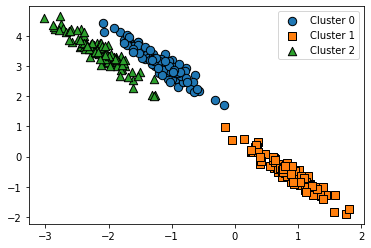

In [25]:
from sklearn.datasets import make_blobs

# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5 을 만듬. 
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 m위해 변환함. 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 셋과 make_blobs( ) 의 y 결과 값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 셋을 target 별로 다른 marker 로 표시하여 시각화 함. 
visualize_cluster(None, clusterDF, 'target', iscenter=False)


## Kmeans 군집화

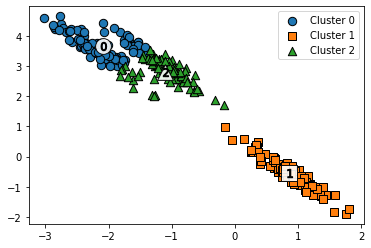

In [26]:
# 3개의 Cluster 기반 Kmeans 를 X_aniso 데이터 셋에 적용 
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster(kmeans, clusterDF, 'kmeans_label',iscenter=True)

## GMM 군집화

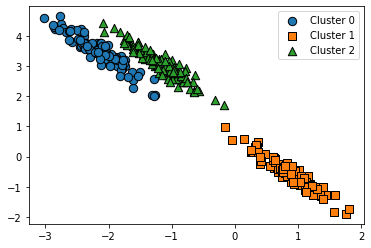

In [29]:
# 3개의 n_components기반 GMM을 X_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정. 
visualize_cluster(gmm, clusterDF, 'gmm_label',iscenter=False)


## GMM Kmeans 군집화 결과 비교

In [30]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
